# TOF Sensor Data Analysis

## Objective

The objective of this notebook is to analyze the effectiveness of WaveShare's Time of Flight (TOF) sensor at measuring distance, and draw conclusions from the data measured.

## Overview

I conducted 3 tiers of testing and data collection:

1. **Basic Tests**: The goal of this level of testing was to determine the accuracy of the TOF sensor in a controlled environment.
2. **Simple Outdoors Tests**: After setting up the sensor on a bicycle, the next level of testing involved riding past stationary objects and determining the accuracy of the data collected, and how effective the sensor was as a binary object detector.
3. **Cycling Tests**: The final level of testing involved using the sensor to measure the distances of cars overtaking the cyclist. The goal of this project is to ultimately collect data on this subject.

In [39]:
import datetime
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

## Basic Tests

* The first object is to determine the distance measuring capabilities of the TOF Sensor.
* I placed the sensor at intervals of 0.5 meters, from 0.5 meters to 5.0 meters, and allowed it to measure the distance for 500 points using the Windows software provided by WaveShare.
* I then take the average of the distances measured at each interval, and compare it to the **acutal** distance.

### WaveShare Documentation

* WaveShare's [documentation](https://www.waveshare.com/wiki/TOF_Laser_Range_Sensor#Specification) states that the accuracy of the TOF sensor would be affected by natural light.
* Furthermore, it gave an estimate of the accuracy and standard deviation depending on the distances measured:

||Short Range (0 to 2.16m)|Mid Range (2.16 to 3.60 m)|Long Range (> 3.60m)|
|---|---|---|---|
|Accuracy|±1.0cm|±1.0cm|±1.5cm|
|Standard Deviation|0.3cm|1.5cm|8cm|

### Setup

- After collecting the dat via the software from WaveShare, I extract the data collected at each interval into a separate excel file. The files can be found in [here](./data/basic_tests/).
- I label each files based on their respective distance interval. For example, at 1.5m, the file is labeled "TOF 1-5".
- Below, I define some constants and helper functions for extracting the data from the excel files.

In [40]:
def get_data_from_excel_file(file_path: pathlib.Path) -> list[int]:
    """
    Get the first 500 points from the excel file.

    Args:
        file_path (pathlib.Path): The path to the excel file.

    Returns:
        list[int]: The first 500 points from the excel file.
    """
    return list(pd.read_excel(file_path)["distance(m)"][:500])


def get_data_from_folder(folder_path: pathlib.Path) -> list[list[int]]:
    """
    Get the first 500 points from each excel file in the folder.

    Args:
        folder_path (pathlib.Path): The path to the folder.

    Returns:
        list[list[int]]: Return an array containing a list for each of the first 500 
                         points from each excel file in the folder.
    """
    data = []
    for file_path in folder_path.iterdir():
        if file_path.suffix == ".xlsx":
            data.append(get_data_from_excel_file(file_path))
    return data


def get_mean_measurements(data: list[list[float]]) -> list[float]:
    """
    Get the mean of the first 500 points from each excel file in the folder.

    Args:
        data (list[list[float]]): A list containing a list of measured points for each interval.

    Returns:
        list[float]: Return an array containing the mean of the points at each interval.
    """
    return [round(np.mean(i), 2) for i in data]


def get_standard_deviations(data: list[list[float]]) -> list[float]:
    """
    Get the standard deviation of the first 500 points from each excel file in the folder.

    Args:
        data (list[list[float]]): A list containing a list of measured points for each interval.

    Returns:
        list[float]: Return an array containing the standard deviation of the points at each interval.
    """
    return [round(np.std(i), 2) for i in data]

In [41]:
ACTUAL_DISTANCES = [0.5 * i for i in range(1, 11)]
OUTDOORS_DATA_PATH = pathlib.Path("./data/basic_tests/outdoors")
INDOORS_DATA_PATH = pathlib.Path("./data/basic_tests/indoors")

outdoors_raw_data = get_data_from_folder(OUTDOORS_DATA_PATH)
indoors_raw_data = get_data_from_folder(INDOORS_DATA_PATH)

### Accuracy - Outdoors vs Indoors

- We evaluate the sensor's accuracy by plotting the mean measured distance at each interval against the actual distance being measured.
- From the graphs below, we can see that the sensor performs far better under indoor conditions where it is not exposed to natural light.
- In the first graph, the sensor gives accurate results until around 3.0m where it seems unable to measure any further.
- However, in the second graph, the sensor measures the actual distance almost perfectly up until 4.0m.
- It is also interesting to see in both graphs that the average measured distances dip at 5.0m. It is possible that this is because of the huge amount of spurious data produced by the sensor as it gets more inaccurate, leading to a lower average.

,0,1,2,3,4,5,6,7,8,9
Actual Distance,0.50,1.0,1.50,2.00,2.5,3.00,3.50,4.00,4.50,5.00
Outdoors Mean,0.50,1.0,1.54,2.11,2.6,2.96,3.28,3.33,3.32,2.96
Indoors Mean,0.52,1.0,1.50,2.02,2.5,3.02,3.52,4.04,4.35,4.06


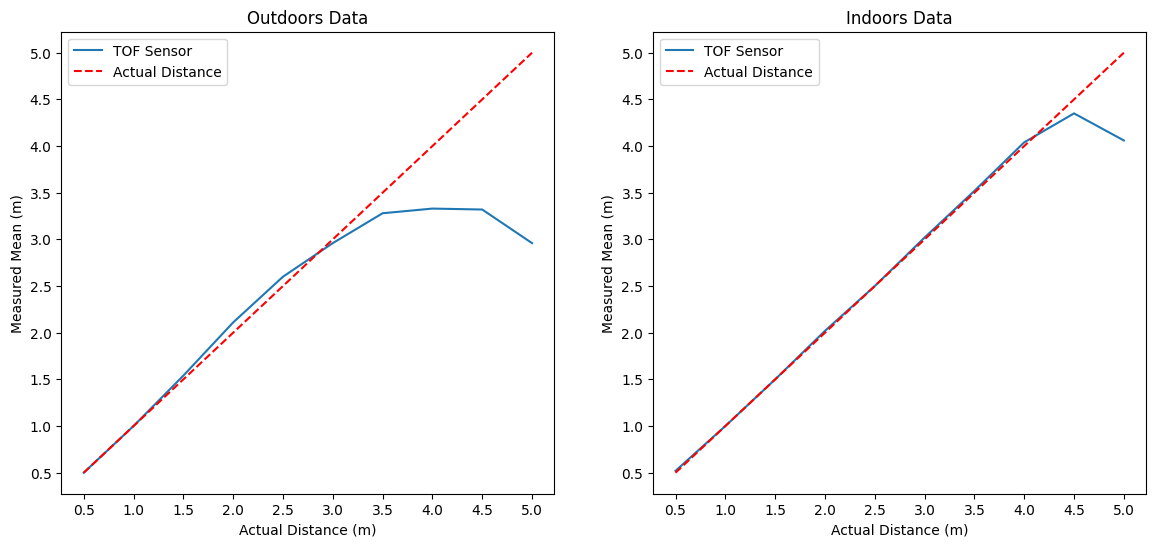

In [42]:
def plot_mean_vs_actual_distance(ax: mpl.axes.Axes, data: list[float], title: str) -> None:
    """
    Plot the measured mean against the actual distance.

    Args:
        ax (mpl.axes.Axes): Matplotlib axes object.
        data (list[float]): data[i] is the mean of the points measured at interval i.
        title (str): Title of the graph
    """
    ax.plot(ACTUAL_DISTANCES, data)
    ax.plot(ACTUAL_DISTANCES, ACTUAL_DISTANCES, color="red", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Actual Distance (m)")
    ax.set_ylabel("Measured Mean (m)")
    ax.set_xticks(ACTUAL_DISTANCES)
    ax.set_yticks(ACTUAL_DISTANCES)
    ax.legend(["TOF Sensor", "Actual Distance"])


outdoors_mean = get_mean_measurements(outdoors_raw_data)
indoors_mean = get_mean_measurements(indoors_raw_data)

data = {
    "Actual Distance": ACTUAL_DISTANCES,
    "Outdoors Mean": outdoors_mean,
    "Indoors Mean": indoors_mean
}
df = pd.DataFrame.from_dict(data)
display(df.T)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_mean_vs_actual_distance(axes[0], outdoors_mean, "Outdoors Data")
plot_mean_vs_actual_distance(axes[1], indoors_mean, "Indoors Data")
plt.show()

### Precision - Outdoors vs Indoors

- Next, we can evaluate the precision of the sensor by plotting a scatter plot of the raw data to see how closely measured points are to each other.
- We can see from the first graph that the sensor is highly unreliable in bright daylight. From 1.5m onwards, the sensor outputs an increasingly large amount of spurious data.
- On the other hand, the second graph reveals that the sensor remains very precise indoors, and up until 3.5m, the amount of spurious data produced remains minimal. 

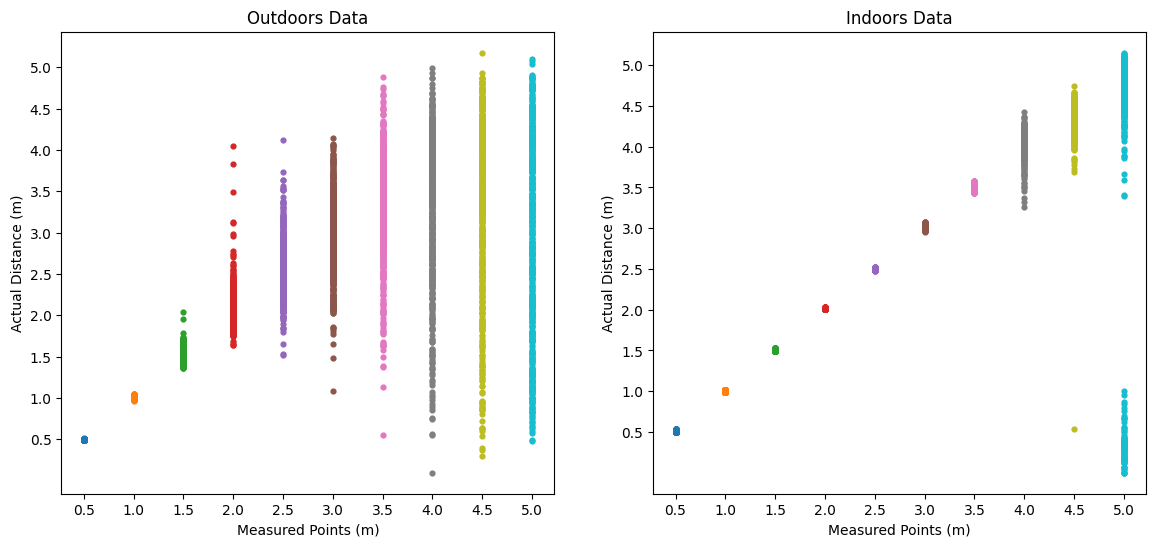

In [71]:
def plot_raw_data(ax: mpl.axes.Axes, data: list[list[float]], title: str) -> None:
    """
    Plot a scatter plot of the raw data.

    Args:
        ax (mpl.axes.Axes): Matplotlib axes object.
        data (list[list[float]]): data[i] is the list of points measured at interval i.
        title (str): Title of the graph
    """
    for i, distance in enumerate(ACTUAL_DISTANCES):
        ax.scatter([distance] * len(data[i]), data[i], s=12)

    ax.set_title(title)
    ax.set_xlabel("Measured Points (m)")
    ax.set_ylabel("Actual Distance (m)")
    ax.set_xticks(ACTUAL_DISTANCES)
    ax.set_yticks(ACTUAL_DISTANCES)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_raw_data(axes[0], outdoors_raw_data, "Outdoors Data")
plot_raw_data(axes[1], indoors_raw_data, "Indoors Data")

### Standard Deviation - Outdoors vs Indoors

- We can also plot the standard deviation of the points measured at each interval.
- Again, we can see that in under strong daylight, the sensor's precision is compromised by it's high standard deviation after interval 2.0m.
- In contrast, in an indoors environment, the standard deviation remains extremely low up until 4.5m onwards.
- This suggests that the amount of spurious data produced by the sensor in daylight is high, affecting it's overall reliability.

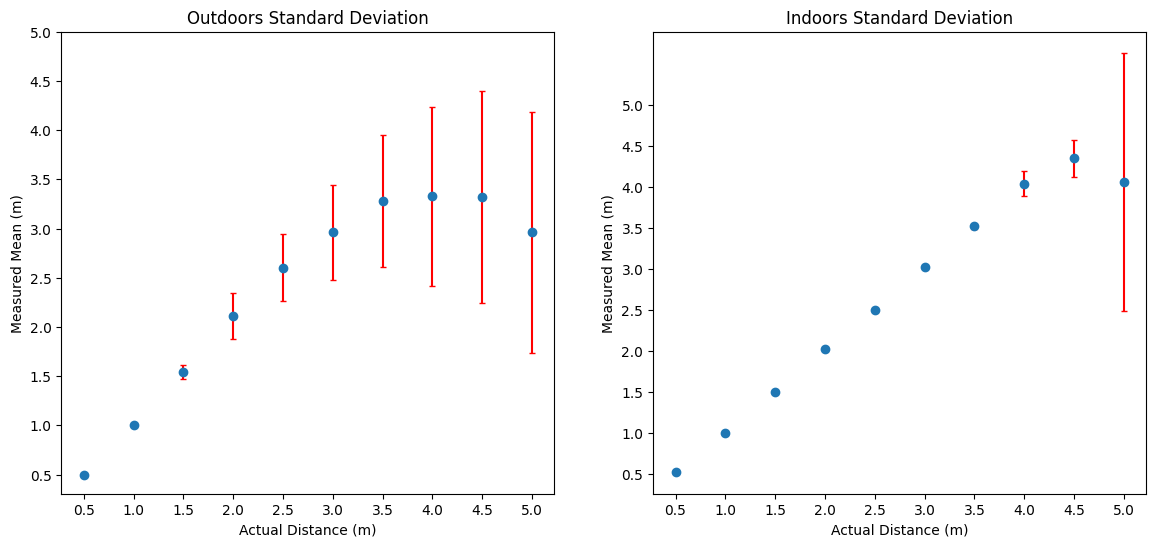

In [74]:
outdoors_std = get_standard_deviations(outdoors_raw_data)
indoors_std = get_standard_deviations(indoors_raw_data)


def plot_std_errorbar(ax: mpl.axes.Axes, data: list[float], std: list[float], title: str) -> None:
    """
    Plot the standard deviation of the measured points against the actual distance.

    Args:
        ax (mpl.axes.Axes): Matplotlib axes object.
        data (list[float]): data[i] is the standard deviation of the points measured at interval i.
        title (str): Title of the graph.
    """
    ax.errorbar(ACTUAL_DISTANCES, data, yerr=std, fmt='o', linestyle='', ecolor="red", capsize=2)
    ax.set_title(title)
    ax.set_xlabel("Actual Distance (m)")
    ax.set_ylabel("Measured Mean (m)")
    ax.set_xticks(ACTUAL_DISTANCES)
    ax.set_yticks(ACTUAL_DISTANCES)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_std_errorbar(axes[0], outdoors_mean, outdoors_std, "Outdoors Standard Deviation")
plot_std_errorbar(axes[1], indoors_mean, indoors_std, "Indoors Standard Deviation")

plt.show()

### Best Fit Curve

- Another way of showing the reliability of the sensor is by drawing a best fit curve through the average measurements at each interval. The closer the line is to a linear, $y = x$ curve, the more accurate it is.
- However, we the amount of spurious data that we have, our best fit curve will not be very accurate.
- Therefore, we can attempt to clean the preprocess the data before fitting it with a curve. One possibility is to remove all points greater than 1 standard deviation from the mean.